In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
df = pd.read_csv('int20h-ds-test-dataset.csv')
df['event_created_date'] = pd.to_datetime(df['event_created_date'])

In [4]:
df['event_name'].unique()

array(['Add Vehicle Success', 'Add Vehicle Break', 'Calculator View',
       'Add Payment Method Success', 'Sign Up Success',
       'Add Payment Method Failed', 'Wallet Opened', 'Transaction Refund',
       'Email Confirmation Success', 'Account Setup Skip',
       'Subscription Premium', 'Chat Conversation Opened',
       'Account Setup Profile Skip',
       'Account History Transaction Details', 'Sign Out',
       'Chat Conversation Started', 'Order', 'Sign Up Error',
       'Subscription Premium Cancel', 'Calculator Used',
       'Subscription Premium Renew', 'Add Vehicle Failed',
       'Reset Password Set'], dtype=object)

# Events

### SIGN UP EVENT
one-time event

In [5]:
signed_up = df.loc[df['event_name'] == 'Sign Up Success']
signed_up_twice = signed_up.loc[signed_up['userid'].duplicated()]['userid'].iloc[0] # the only person signed up twice, probably a bug
df = df.loc[~(df['userid'] == signed_up_twice)]

# People who signed up before 2022 (no record of signing up)
signed_up_before2022 = list(set(df['userid'].unique()) - set(df.loc[df['event_name'] == 'Sign Up Success', 'userid'].unique()))


In [6]:
sign_up_source = signed_up['event_attributes'].apply(lambda x: json.loads(x)['Method'])

In [7]:
sign_up_source.index = signed_up['userid']

- removed 1 person from df that signed up twice (probably bug)
- `signed_up_before2022` - list of userids that have no record of signing up
- `sign_up_source` - pd.Series with index 'userid' and values of string either Google Facebook Apple or Email

### SIGN UP ERROR EVENT

In [8]:
# One person failed to sign up
sign_up_failed = set(df.loc[df['event_name'] == 'Sign Up Error']['userid']) - set(signed_up['userid'])


In [9]:
# Remove that person from the dataset as 'outlier'
df=df.loc[~(df['userid'] == list(sign_up_failed)[0])]

In [10]:
signed_up_before2022.remove(list(sign_up_failed)[0])

- removed 1 person that could not success in signing up
- this feature can be removed as all other users signed up after an error

In [11]:
df = df.loc[~(df['event_name'] == 'Sign Up Error')]

### ACCOUNT SETUP SKIP EVENT
one-time event

In [12]:
setup_skip = df.loc[(df['event_name'] == 'Account Setup Skip') | (df['event_name'] == 'Account Setup Profile Skip')]
skipped_twice_ind = setup_skip.loc[setup_skip['userid'].duplicated()].index
df.drop(skipped_twice_ind, inplace=True)

- Removed 4 rows that had skipped account setup second time

### Email Confirmation Success event
one-time event

In [13]:
email_confirmed = df.loc[df['event_name'] == 'Email Confirmation Success']
email_confirmed_multiple_ind = email_confirmed.loc[email_confirmed['userid'].duplicated()].index
df.drop(email_confirmed_multiple_ind, inplace=True)

- Removed rows that confirmed more than 1 email, only interested in email confirmed/not confirmed

### Reset Password Set event
not useful at all. Deleted all rows with this event

In [14]:
df = df.loc[~(df['event_name'] == 'Reset Password Set')]

### Add Payment Method Success event

In [15]:
added_card = df.loc[df['event_name'] == 'Add Payment Method Success']
df.loc[df['event_name'] == 'Add Payment Method Success', 'event_name'] = added_card['event_attributes'].apply(lambda x: 'payment_method_added_' + json.loads(x)['Payment Method'])
not_added_card = list(set(df['userid'].unique()) - set(added_card['userid'].unique()))


encode by method added or no_card_added

### Add Vehicle Success event

In [16]:
add_vehicle = df.loc[df['event_name'] == 'Add Vehicle Success']
df.loc[df['event_name'] == 'Add Vehicle Success', 'event_name'] = add_vehicle['event_attributes'].apply(lambda x: 'add_vehicle_temporary' if json.loads(x)['Temporary'] == 'true' else 'add_vehicle_permanently')

not_added_vehicle = list(set(df['userid'].unique()) - set(add_vehicle['userid'].unique()))



split event to permanently/temporary added or not_added vehicle

### Add vehicle break event

In [17]:
add_vehicle_break = df.loc[df['event_name'] == 'Add Vehicle Break']
break_adding_vehicle = list(set(add_vehicle_break['userid']) - set(add_vehicle['userid']))

In [18]:
not_added_vehicle = list(set(not_added_vehicle)-set(break_adding_vehicle))

- `break_adding_vehicle` - list of users who started adding vehicles but gave up
- removed those users from `not_added_vehicle`, it will represent people who hasn't tried

In [19]:
df = df.loc[~(df['event_name'] == 'Add Vehicle Break')]

### Add Vehicle Failed event

Only 3 users could not add the vehicle after Add Vehicle Failed event. Feature is useless, so deleted it

In [20]:
df = df.loc[~(df['event_name'] == 'Add Vehicle Failed')]

### Subscription Premium event
One-time event

In [21]:
sub = df.loc[df['event_name'] == 'Subscription Premium']
subscribed = sub['userid']
subscribtion_time = sub['event_created_date']
subscribtion_time.index = sub['userid']

- `subscribtion_time` - pd.Series with time of subscription. index is the user's id

### Subscription Premium Renew event
mulitiple-time event

In [22]:
sub_renew = df.loc[df['event_name'] == 'Subscription Premium Renew']
no_renewal = list(set(sub['userid']) - set(sub_renew['userid']))

- `no_renewal` - list of users that subscribed but have not renewed
- encode others to have the number of renewals as column

### Subscription Premium Cancel event
one-time event, the target

In [23]:
sub_cancel = df.loc[df['event_name'] == 'Subscription Premium Cancel']
# some people have cancelled the subscription twice, but all except one duplicates have the same timestamp, so its a bug
cancelled_twice = sub_cancel.loc[sub_cancel['userid'].duplicated()]['userid'] 


In [24]:
# One person has renewed subscription after cancelling it, but after that cancelled again. Let's remove first cancellation
for canc_ind in sub_cancel.index:
    user = sub_cancel['userid'][canc_ind]
    df_after = df.iloc[canc_ind:]
    if not (df_after.loc[(df_after['userid'] == user) & (df_after['event_name'] == 'Subscription Premium Renew')].empty):
        df.drop(canc_ind, inplace=True)
        

In [25]:
df.drop(cancelled_twice.index, inplace=True) # Removed duplicated unsubs caused by a bug

In [26]:
canc_immediately = set()

for canc_ind in sub_cancel.index:
    user = sub_cancel['userid'][canc_ind]
    # Dropping all user's events after unsubscribing
    df.drop(df.iloc[canc_ind:].loc[df['userid'] == user].index)
    
    # Find users that unsubscribed the same day as subscribed (61 users)
    try:
        if (sub_cancel['event_created_date'][canc_ind] - subscribtion_time[user]).days < 1:
            canc_immediately.add(user)
    except KeyError:
        pass
    
canc_immediately = list(canc_immediately)

In [27]:
len(canc_immediately)

61

- 61 users unsubscribed the same day they subscribed. They probably made a mistake or initially intended to subscribe for 1 month only. `canc_immediately` holds their userids. Better to analyze them separately
- dropped the rows with double unsubscription
- dropped the rows after unsubscription since they don't help predicting unsubscription event


### Transaction Refund event

In [28]:
tr_refund = df.loc[df['event_name'] == 'Transaction Refund']
tr_refund['event_attributes'] = tr_refund['event_attributes'].apply(lambda x: -1*float(json.loads(x)['Amount']))

C:\Users\Asus\AppData\Local\Temp\ipykernel_66472\423094729.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr_refund['event_attributes'] = tr_refund['event_attributes'].apply(lambda x: -1*float(json.loads(x)['Amount']))


In [29]:
refund_sizes = tr_refund.groupby('userid').sum('event_attributes')

- `refund_sizes` - pd.Series with sum value of user's refunds and userid as index

### Calculator View event

Nothing interesting, just need to encode

### Wallet Opened event

Nothing interesting, just need to encode

### Chat Conversation Opened event

In [30]:
chat_opened = df.loc[df['event_name'] == 'Chat Conversation Opened']
chat_opened.loc[chat_opened['event_attributes'] == '{}', 'event_attributes'] = '{"From": ""}'
df.loc[df['event_name'] == 'Chat Conversation Opened', 'event_name'] = chat_opened['event_attributes'].apply(lambda x: 'chat_opened_from_' + json.loads(x)['From'])

- `chat_opened_attrs` - pd.Series with attribute where chat was opened from. index is the same as df

### Account History Transaction Details event

Nothing interesting, just need to encode

### Sign Out event

In [31]:
sign_out = df.loc[df['event_name'] == 'Sign Out']
df.loc[df['event_name'] == 'Sign Out', 'event_name'] = sign_out['event_attributes'].apply(lambda x: 'sign_out_' + json.loads(x)['Type'])


- `sign_out_type` pd.Series telling was user signed out manually or automatically. index is the same as df's

### Chat Conversation Started event

Nothing interesting just need to encode

### Calculator Used event

Nothing interesting just need to encode

### Order event

In [32]:
orders = df.loc[df['event_name'] == 'Order']
df.loc[df['event_name'] == 'Order', 'event_name'] = orders['event_attributes'].apply(lambda x: 'Premium_order' if json.loads(x)['Premium Membership'] == 'True' else 'NonPremium_order')




- split order event to Premium_order event and NonPremium_order

In [33]:
df

,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model
0,c95c777785faec8dd910d019d7278ebe,CA,add_vehicle_permanently,"{""Make"":""Dodge"",""Model"":""Caravan"",""Color"":""Whi...",2022-01-16 17:03:04,android,samsung,SM-N975U
2,f344be2d9a042b7444f3cc5279e38ef1,FL,Calculator View,{},2022-01-16 17:16:25,android,samsung,SM-G973U1
3,c95c777785faec8dd910d019d7278ebe,CA,payment_method_added_Credit,"{""Payment Method"":""Credit"",""Tokenized Pay"":""""}",2022-01-16 17:24:22,android,samsung,SM-N975U
4,e331ed81422d8fba55520a43a872e701,IL,Sign Up Success,"{""Method"":""Apple""}",2022-01-16 17:34:51,ios,Apple,"iPhone12,1"
5,f6d930969a59cfb488ed4d126c7c856d,TX,Sign Up Success,"{""Method"":""Google""}",2022-01-16 18:26:41,android,samsung,SM-A716U
...,...,...,...,...,...,...,...,...
23351,59e61796833e7e9edcb7796fac1688ba,FL,add_vehicle_permanently,"{""Year"":""2015"",""Model"":""Hino"",""Temporary"":""fal...",2022-04-16 15:15:41,ios,Apple,"iPhone13,1"
23352,679eba26c4e75e0afb178360becfa21b,CA,payment_method_added_Credit,"{""Payment Method"":""Credit"",""Tokenized Pay"":"""",...",2022-04-16 20:49:24,android,Google,Pixel 3a
23353,679eba26c4e75e0afb178360becfa21b,CA,Account Setup Profile Skip,"{""Screen"":""Address""}",2022-04-16 20:50:05,android,Google,Pixel 3a
23355,679eba26c4e75e0afb178360becfa21b,CA,chat_opened_from_Dashboard,"{""From"":""Dashboard"",""Transaction type"":""""}",2022-04-16 20:50:31,android,Google,Pixel 3a


# Other Features

In [34]:
df['device_manufacture'].fillna('outofband', inplace=True)

In [35]:
# Drop device model as it is not likely to matter
df.drop('device_model', axis=1, inplace=True)

In [36]:
# Device manufactures other than samsung,Apple,Google are marked 'Other'
df.loc[~(df['device_manufacture'].isin(['Apple', 'Google', 'samsung', 'outofband'])), 'device_manufacture'] = 'Other'

In [37]:
# Event platfrom is not needed since we keep device_manufacture.
df.drop('event_platform', axis=1, inplace=True)

In [38]:
# ??? Drop state бо нашо
df.drop('user_state', axis=1, inplace=True)

In [39]:
# бо враховано
df.drop('event_attributes', axis=1, inplace=True)

In [40]:
df

,userid,event_name,event_created_date,device_manufacture
0,c95c777785faec8dd910d019d7278ebe,add_vehicle_permanently,2022-01-16 17:03:04,samsung
2,f344be2d9a042b7444f3cc5279e38ef1,Calculator View,2022-01-16 17:16:25,samsung
3,c95c777785faec8dd910d019d7278ebe,payment_method_added_Credit,2022-01-16 17:24:22,samsung
4,e331ed81422d8fba55520a43a872e701,Sign Up Success,2022-01-16 17:34:51,Apple
5,f6d930969a59cfb488ed4d126c7c856d,Sign Up Success,2022-01-16 18:26:41,samsung
...,...,...,...,...
23351,59e61796833e7e9edcb7796fac1688ba,add_vehicle_permanently,2022-04-16 15:15:41,Apple
23352,679eba26c4e75e0afb178360becfa21b,payment_method_added_Credit,2022-04-16 20:49:24,Google
23353,679eba26c4e75e0afb178360becfa21b,Account Setup Profile Skip,2022-04-16 20:50:05,Google
23355,679eba26c4e75e0afb178360becfa21b,chat_opened_from_Dashboard,2022-04-16 20:50:31,Google


In [41]:
df[['event_created_date', 'device_manufacture']] = df[['event_created_date', 'device_manufacture']].applymap(lambda x: [x])
df = pd.get_dummies(df, prefix='event', columns=['event_name'])
df




,userid,event_created_date,device_manufacture,event_Account History Transaction Details,event_Account Setup Profile Skip,event_Account Setup Skip,event_Add Payment Method Failed,event_Calculator Used,event_Calculator View,event_Chat Conversation Started,...,event_chat_opened_from_Dashboard,event_chat_opened_from_Deeplink,event_chat_opened_from_Menu,event_chat_opened_from_Transaction Details,event_payment_method_added_Credit,event_payment_method_added_Debit,event_payment_method_added_PayPal,event_payment_method_added_Venmo,event_sign_out_Auto,event_sign_out_Manual
0,c95c777785faec8dd910d019d7278ebe,[2022-01-16 17:03:04],[samsung],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,f344be2d9a042b7444f3cc5279e38ef1,[2022-01-16 17:16:25],[samsung],0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,c95c777785faec8dd910d019d7278ebe,[2022-01-16 17:24:22],[samsung],0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,e331ed81422d8fba55520a43a872e701,[2022-01-16 17:34:51],[Apple],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,f6d930969a59cfb488ed4d126c7c856d,[2022-01-16 18:26:41],[samsung],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23351,59e61796833e7e9edcb7796fac1688ba,[2022-04-16 15:15:41],[Apple],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23352,679eba26c4e75e0afb178360becfa21b,[2022-04-16 20:49:24],[Google],0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
23353,679eba26c4e75e0afb178360becfa21b,[2022-04-16 20:50:05],[Google],0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23355,679eba26c4e75e0afb178360becfa21b,[2022-04-16 20:50:31],[Google],0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [42]:
df = df.groupby('userid').sum(numeric_only=False)

In [43]:
df['event_created_date'] = df['event_created_date'].apply(lambda x: x[-1] - x[0])
df['device_manufacture'] = df['device_manufacture'].apply(lambda x: list(set(x)))
# Not interested in users with only 1 event
df = df.loc[(df['event_created_date'] > pd.Timedelta(0))]

<AxesSubplot:xlabel='event_Subscription Premium Cancel'>

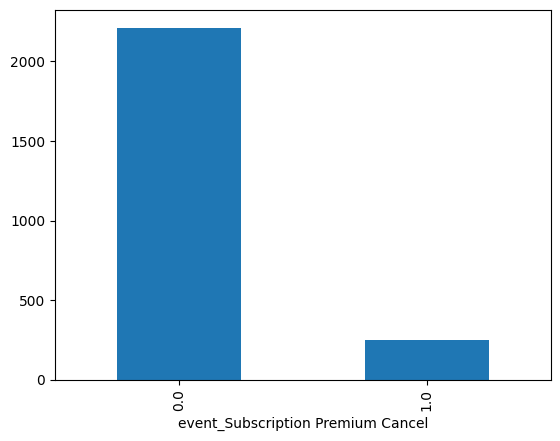

In [44]:
df.groupby(['event_Subscription Premium Cancel']).count()['event_created_date'].plot.bar()

In [45]:
# Encode device manufacture
from sklearn.preprocessing import MultiLabelBinarizer
device_manuf = df['device_manufacture']
mlb = MultiLabelBinarizer()
device_df = pd.DataFrame(mlb.fit_transform(device_manuf),
                   columns=mlb.classes_,
                   index=device_manuf.index)

df = pd.concat([df, device_df], axis=1, join='inner')
df.drop(['device_manufacture', 'outofband'], axis=1, inplace=True)


In [46]:
df['event_created_date'] = df['event_created_date'] // pd.Timedelta(hours=1) # time in hours between first and last event
df

,event_created_date,event_Account History Transaction Details,event_Account Setup Profile Skip,event_Account Setup Skip,event_Add Payment Method Failed,event_Calculator Used,event_Calculator View,event_Chat Conversation Started,event_Email Confirmation Success,event_NonPremium_order,...,event_payment_method_added_Credit,event_payment_method_added_Debit,event_payment_method_added_PayPal,event_payment_method_added_Venmo,event_sign_out_Auto,event_sign_out_Manual,Apple,Google,Other,samsung
userid,,,,,,,,,,,,,,,,,,,,,
0006869712ec9841dc36234bce245203,726,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,1
003f57fe2631ade57a86f6a2b96bb20c,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
00596aa4edee32815aaf4aad659c484e,403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0,0,0,1
0079e6902320d6771024a236ab801f2e,447,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,1
007b54670d72df309afd87befcbb63db,17,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff530883fc9c83ac50418d8672e9056e,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
ff72157f48e62a7278d4efb45e876a4e,0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
ff7f35641a4cd9f6779c8d05381feb32,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0


In [47]:
for ind in df.index:
    if ind in sign_up_source.index:
        df.loc[ind, 'event_Sign Up Success'] = sign_up_source[ind]
# Encode sign up source, sign_up_0 means no record of signing up, probably signed up before 2022
df = pd.get_dummies(df, prefix='sign_up', columns=['event_Sign Up Success'])
df

,event_created_date,event_Account History Transaction Details,event_Account Setup Profile Skip,event_Account Setup Skip,event_Add Payment Method Failed,event_Calculator Used,event_Calculator View,event_Chat Conversation Started,event_Email Confirmation Success,event_NonPremium_order,...,event_sign_out_Manual,Apple,Google,Other,samsung,sign_up_0.0,sign_up_Apple,sign_up_Email,sign_up_Facebook,sign_up_Google
userid,,,,,,,,,,,,,,,,,,,,,
0006869712ec9841dc36234bce245203,726,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,1,1,0,0,0,0
003f57fe2631ade57a86f6a2b96bb20c,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1,0,0,0,0,1,0,0,0
00596aa4edee32815aaf4aad659c484e,403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,1,0,0,0,0,1
0079e6902320d6771024a236ab801f2e,447,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0,0,0,1,0,0,0,0,1
007b54670d72df309afd87befcbb63db,17,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff530883fc9c83ac50418d8672e9056e,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,0,0,0,0,1,0,0,0
ff72157f48e62a7278d4efb45e876a4e,0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,0,0,0,0,0,0,0,1
ff7f35641a4cd9f6779c8d05381feb32,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1,0,0,0,0,0,0,0,1


In [48]:
df['no_card_added'] = 0
df.loc[df.index.isin(not_added_card), 'no_card_added'] = 1

In [49]:
df['didnt_try_adding_vehicle'] = 0
df['gave_up_adding_vehicle'] = 0
df.loc[df.index.isin(not_added_vehicle), 'didnt_try_adding_vehicle'] = 1
df.loc[df.index.isin(break_adding_vehicle), 'gave_up_adding_vehicle'] = 1

In [50]:
df['subscribed_for_1_month_only'] = 0
df.loc[df.index.isin(no_renewal), 'subscribed_for_1_month_only'] = 1

In [51]:
for ind in df.index:
    if ind in refund_sizes.index:
        df.loc[ind, 'event_Transaction Refund'] = refund_sizes.loc[ind].iloc[0]

In [52]:
df = df.rename({'event_created_date': 'first_to_last_event_hours', 'sign_up_0': 'signed_up_before2022'}, axis=1)

In [53]:
df_main = df.loc[~df.index.isin(canc_immediately)]

In [57]:
df_main.to_csv("int20h_processed.csv", index=False)